# Methods for Homework 2, Team 2
## DSC291 - Data Science for Scientists and Engineers

This notebook demonstrates how we use aws-jupyter to 
- automatically start EC2 instances of different types
- run the same timed script on all these instances
- retrieve the results from all instances
- and combine all results with pricing data to compare the performance of different instances

While this notebook does not describe our actual experiment (we're submitting another one for that), it is meant as a general desription of how it is possible to use aws-jupyter to run any such experiment. 

**Run the last cell to turn this notebook into a presentation!**

*Note: To successfully run this notebook, it's easiest to start it in the conda environment for packages availability.*

    $conda activate
$jupyter notebook


In [2]:
# import stuff
from os.path import isfile,isdir
from os import mkdir,chdir,getcwd
import pickle as pk
import pandas as pd
import numpy as np
import subprocess
from time import sleep
import argparse

# enable inline graphics
%pylab inline  

Populating the interactive namespace from numpy and matplotlib


### We start by listing the instances that are active on our account. 
This can be helpful, to monitor whether there are any unused instances that are still running, and costing us money.

(also, we still haven't been given access to https://ets-apps.ucsd.edu/dsc291-custom-aws/index.cgi, so this is our solution to try to make sure that our costs are not piling up...)

In [2]:
!aws ec2 describe-instances \
    --query 'Reservations[*].Instances[*].{Type:InstanceType,\
                                           LaunchTime:LaunchTime,\
                                           Instance:InstanceId,\
                                           KeyName:KeyName,\
                                           State:State.Name,\
                                           Name:Tags[?Key==`cluster-name`]|[0].Value}' \
    --output table

--------------------------------------------------------------------------------------------------------------------------------
|                                                       DescribeInstances                                                      |
+---------------------+---------------------+---------------------------+-------------------------+--------------+-------------+
|      Instance       |       KeyName       |        LaunchTime         |          Name           |    State     |    Type     |
+---------------------+---------------------+---------------------------+-------------------------+--------------+-------------+
|  i-0b4273fb72510e2d9|  PSADSC291KeyPair   |  2020-04-19T20:39:17.000Z |  dsc291hw2TESTt3small   |  terminated  |  t3.small   |
|  i-0e4ccb193e3cdcdc8|  PSADSC291KeyPair   |  2020-04-19T21:43:13.000Z |  dsc291hw2TEST2t3small  |  terminated  |  t3.small   |
|  i-0c71d929d331d1a9d|  SGabaDSC291KeyPair |  2020-04-16T18:44:26.000Z |  sgaba-test            

### Here are a few options for stopping or terminating instances 
This one is just an example for if one notices any instances that seem to have been running for a while whithout usage. In that case we can uncomment a line and terminate/stop them manually by their instance ID. 

In [3]:
# !aws ec2 stop-instances --instance-ids "i-0105aaca12dbcb0e1" "i-0f36f5a941f2fee32"
# !aws ec2 stop-instances --instance-ids "i-0c71d929d331d1a9d" --hibernate
# !aws ec2 terminate-instances --instance-ids "i-06db20077a6e44cad"
# !aws ec2 terminate-instances --instance-ids "i-0e4ccb193e3cdcdc8" "i-03e1edfe2e3dfbebe" "i-097fb433d4ae7cbf5"

### Now let's import some data on which instance types are available, and how much they cost.
We will use a subset of the instanceType list to start multiple EC2 instances which we want to compare. We will use the pricing data later on, to compare performance to pricing. 

In [3]:
pricedf = pd.read_csv('ec2ondemandprices20200419.csv')
pricedf

,instanceType,vCPU,ECU,memoryGB,instanceStorage,priceHour,category
0,t3.nano,2,Variable,0.5 GiB,EBS Only,$0.0062 per Hour,general purpose
1,t3.micro,2,Variable,1 GiB,EBS Only,$0.0125 per Hour,general purpose
2,t3.small,2,Variable,2 GiB,EBS Only,$0.025 per Hour,general purpose
3,t3.medium,2,Variable,4 GiB,EBS Only,$0.0499 per Hour,general purpose
4,t3.large,2,Variable,8 GiB,EBS Only,$0.0998 per Hour,general purpose
5,t3.xlarge,4,Variable,16 GiB,EBS Only,$0.1997 per Hour,general purpose
6,t3.2xlarge,8,Variable,32 GiB,EBS Only,$0.3994 per Hour,general purpose
7,m5.large,2,10,8 GiB,EBS Only,$0.115 per Hour,general purpose
8,m5.xlarge,4,16,16 GiB,EBS Only,$0.23 per Hour,general purpose
9,m5.2xlarge,8,37,32 GiB,EBS Only,$0.461 per Hour,general purpose


Here, we are making price column numeric. Then, for this initial test we select only the cheapest instances, to prevent spending too much money on something that might not work. 

In [7]:
if pricedf['priceHour'].dtype == 'O':
    pricedf['priceHour'] = pd.to_numeric(pricedf.priceHour.str.extract('(\d*\.?\d.?\d.?\d.)')[0])

priceCutOff = 0.5
dfTest = pricedf[pricedf['priceHour'] < priceCutOff]

typeList = dfTest['instanceType'].tolist()
priceList = np.round(dfTest['priceHour'].tolist(),4)
print(typeList)
print(priceList)

['t3.nano', 't3.micro', 't3.small', 't3.medium', 't3.large', 't3.xlarge', 't3.2xlarge', 'm5.large', 'm5.xlarge', 'm5.2xlarge', 'c5.large', 'c5.xlarge', 'c5.2xlarge', 'r5.large', 'r5.xlarge', 'r5d.large', 'r5d.xlarge', 'i3en.large']
[0.0062 0.0125 0.025  0.0499 0.0998 0.1997 0.3994 0.115  0.23   0.461
 0.102  0.204  0.408  0.151  0.302  0.173  0.346  0.271 ]


### We'll have to set up each instance before running our test
Here, we are creating a script that we will run on each instance to set it up. (This is basically copy-pasted from the class materials.)

In [8]:
startup_script = '''git clone https://github.com/fliphilipp/Public-DSC291
sudo pip install psutil

# run the following if the instance has an SSD that needs to be formatted and mounted.

lsblk
sudo mkfs.ext4 -E nodiscard -m0 /dev/nvme0n1   #format
sudo mkdir /home/ubuntu/spda                   #make root for mounting
sudo mount -o discard /dev/nvme0n1 /home/ubuntu/spda # mount
ln -s /home/ubuntu/spda scratch                #create local link
sudo chmod a+rwx scratch                       # make read/write-able
lsblk'''

theFile = open('startup.sh','w') 
theFile.write(startup_script) 
theFile.close() 

In [29]:
# make sure this worked
!cat startup.sh

git clone https://github.com/fliphilipp/Public-DSC291
sudo pip install psutil

# run the following if the instance has an SSD that needs to be formatted and mounted.

lsblk
sudo mkfs.ext4 -E nodiscard -m0 /dev/nvme0n1   #format
sudo mkdir /home/ubuntu/spda                   #make root for mounting
sudo mount -o discard /dev/nvme0n1 /home/ubuntu/spda # mount
ln -s /home/ubuntu/spda scratch                #create local link
sudo chmod a+rwx scratch                       # make read/write-able
lsblk

### Python wrapper for aws-jupyter
To use aws-jupyter effectively from a notebook, we are adding some code that makes it easier to run commands from here. 

In [10]:
def run_command(command,debug=False):
    if debug:
        print('running ',command)
    p=subprocess.Popen(command.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out=p.communicate()
    stdout=out[0].decode()
    stderr=out[1].decode()
    outputs={"stderr":stderr,
             "stdout":stdout}
    if debug:
        print(outputs)
    return outputs

In [11]:
class aws_jupyter:
    """
    A python wrapper around the script **aws-jupyter**
    """
    
    def check(self):
        """
        Check on the status of the ec2 instance
        Returns status
        -------
        0 = No instance running under this name 
        
        1 = instance in the process of starting up
        
        2 = instance available        
        
        -1 = Status could not be parsed
        """
        check_cmd = "aws-jupyter check --name %s"%self.name
        self.decoded=run_command(check_cmd)
        stdout=self.decoded['stdout']
        if('The Jupyter Notebook is running on the cluster at the address below.' in stdout):
            print(stdout)
            return 2
        elif("No instance found in the cluster" in stdout):
            return 0
        elif("Cluster is not ready. Please check again later." in stdout):
            return 1
        else:
            print(" ...did not recognize check status")
            # print(stdout)
            return -1

    def run(self,scriptname,files=[],credentials="",waitforoutput=True,printoutput=False): 
        """
        Run a local script on the remote instance
        Parameters
        ----------
        scriptname : TYPE
            DESCRIPTION.
        files : TYPE, optional
            DESCRIPTION. The default is [].
        credentials : TYPE
            DESCRIPTION.
        waitforoutput : TYPE, optional
            DESCRIPTION. The default is True.
        Returns
        -------
        None.
        """
            
        running_cmd = "aws-jupyter run -s {script}"
        runcmd = running_cmd.format(script=scriptname)
        if len(files)>0:
            runcmd += " --files"
            for i in range(len(files)):
                runcmd += " {fn}".format(fn=files[i])
        if waitforoutput:
            runcmd += " --output"
        print("running command: {runcmd}".format(runcmd=runcmd))
        out = run_command(runcmd,debug=False)
        if printoutput:
            print(out['stdout'])
            print(out['stderr'])

    def retrieve():
        """ call aws-jupyter retrieve"""
        return
    
    def terminate(self,printoutput=False):
        """ call aws-jupyter terminate"""
        term_cmd = "yes | aws-jupyter terminate --name %s" % self.name
        print("terminate instance: {term_cmd}".format(term_cmd=term_cmd))
        out = run_command(term_cmd)
        if printoutput:
            print(out['stdout'])
            print(out['stderr'])
            
    def __init__(self,name='instance',count=1,_type='t3.large',spot=0):
        """
        Create a cluster of instances on ec2
        Parameters
        ----------
        name : TYPE, optional
            DESCRIPTION. The default is 'instance'.
        count : TYPE, optional
            DESCRIPTION. The default is 1.
        _type : TYPE, optional
            DESCRIPTION. The default is 't3.large'.
        spot : TYPE, optional
            DESCRIPTION. The default is 0.
        Returns
        -------
        None.
        """
        self.name=name
        status=self.check()
        if status==1:
            print("cluster %s not ready yet"%self.name)
            return
        elif status==2:
            print("cluster running")
            return

        create_cmd = "aws-jupyter create -c {count} --name {name} --type {_type}"
        command=create_cmd.format(count=count,name=name,_type=_type)
        if spot>0:
            command.append(" --spot %4.2f"%spot)
        out=run_command(command)
        print("initiated instance:",command)
 
        i=0; wait_period=10
        while True:
            status=self.check()
            if status==2:
                # print(stdout)
                break
            print('\r check',i*wait_period,end='')
            i+=1
            sleep(wait_period)

### A test script to run on each instance

Here, we are defining a test script that we will be running on each instance. The calculations to be done are timed a hundred times, and the results are written to a pickle file. 

For this test, we are just running a quick and simple task (finding the 100,000th Fibonacci number recursively). For our actual experiment, this script is more involved. 

In [12]:
program_to_run = '''#!/usr/bin/env python3

import numpy as np
from time import time
from os.path import isfile,isdir
from os import mkdir,chdir,getcwd
import pickle as pk

times = []
nTrials = 100
nFibonacci = 10**5

# a dumb random computational task, on which to compare instances
inst_starttime = time()
for k in range(nTrials):
    starttime = time()
    fibonacci_previous = 1
    fibonacci_current = 1
    for i in range(2,nFibonacci):
        fibonacci_next = fibonacci_previous + fibonacci_current
        fibonacci_previous = fibonacci_current
        fibonacci_current = fibonacci_next
    DT = time() - starttime
    times.append(DT)
print(time() - inst_starttime)
    
#hist(times,bins=50)
exec_dir = getcwd()
log_dir = exec_dir + '/measurement_logs/'
if not isdir(log_dir):
    mkdir(log_dir)
fn = log_dir + 'stats.pkl'
with open(fn,'wb') as times_pkl:
    pk.dump(times,times_pkl,protocol=pk.HIGHEST_PROTOCOL)'''

theFile = open('ec2testFibonacci.py','w') 
theFile.write(program_to_run) 
theFile.close() 

### Before we start, let's check which instances we will actually be using.
We can also further make the list shorter here, if we are just trying to see if this notebook works.

In [14]:
# if you want to just try, say, 3 different ones for testing
# typeList = typeList[0:3]
typeList

['t3.nano',
 't3.micro',
 't3.small',
 't3.medium',
 't3.large',
 't3.xlarge',
 't3.2xlarge',
 'm5.large',
 'm5.xlarge',
 'm5.2xlarge',
 'c5.large',
 'c5.xlarge',
 'c5.2xlarge',
 'r5.large',
 'r5.xlarge',
 'r5d.large',
 'r5d.xlarge',
 'i3en.large']

## Now lets start all instances in the list and run our timed experiment multiple times!
This is where things actually happen. 


In [ ]:
# create a directory in which we will collect test results from different instance types
remotedir = 'from_remote'
if not isdir(remotedir):
    mkdir(remotedir)

# now loop through all instance types that we want to test, and actually run the test on them
for thisType in typeList:
    thisName = "h2" + thisType.replace('.','')
    
    # initiate instance and run startup
    thisInst = aws_jupyter(name=thisName, count=1, _type=thisType)
    thisInst.run(scriptname='startup.sh',printoutput=True)
    
    # run the test script
    thisInst.run(scriptname='ec2testFibonacci.py',printoutput=True)
    
    # retrieve files
    !sleep 120
    !aws-jupyter retrieve --remote /home/ubuntu/workspace/measurement_logs/stats.pkl --local from_remote/
    new_fn = 'from_remote/stats_' + thisType.replace('.','-') + '.pkl'
    !mv from_remote/worker-0/stats.pkl $new_fn
    
    # terminate instances
    # thisInst.terminate(printoutput=True)  # <--- somehow this doesn't work!
    !yes | aws-jupyter terminate --name $thisInst.name

### Print out a list of our instances again
To make sure we've terminated them!

In [25]:
# , to make sure we've terminated them
!aws ec2 describe-instances \
    --query 'Reservations[*].Instances[*].{Type:InstanceType,\
                                           LaunchTime:LaunchTime,\
                                           Instance:InstanceId,\
                                           KeyName:KeyName,\
                                           State:State.Name,\
                                           Name:Tags[?Key==`cluster-name`]|[0].Value}' \
    --output table

--------------------------------------------
|             DescribeInstances            |
+-------------+----------------------------+
|  Instance   |  i-0c71d929d331d1a9d       |
|  KeyName    |  SGabaDSC291KeyPair        |
|  LaunchTime |  2020-04-16T18:44:26.000Z  |
|  Name       |  sgaba-test                |
|  State      |  stopped                   |
|  Type       |  m3.xlarge                 |
+-------------+----------------------------+


### Now, get all the collected data back into this notebook
Here, we create a pandas dataframe with all the data collected from the different types of instances. We need to collect the data from all the different files that were sent back to us from the different instances we've created.

We can print the first few lines of the dataframe to see if the data looks about right. 

*Here, something must have gone wrong on the instance of type **c5.large** that we had created. The output logs (which were deleted because they contained our AWS credentials) seem to indicate that the ssh connection failed when trying to retrieve the file with the results.*

In [17]:
results = pd.DataFrame(columns = typeList)
for thisType in typeList:
    filename = 'from_remote/stats_' + thisType.replace('.','-') + '.pkl'
    if isfile(filename):
        infile = open(filename,'rb')
        thisData = pk.load(infile)
        infile.close()
        results[thisType] = thisData

# display the top of the dataframe
results.head()

,t3.nano,t3.micro,t3.small,t3.medium,t3.large,t3.xlarge,t3.2xlarge,m5.large,m5.xlarge,m5.2xlarge,c5.large,c5.xlarge,c5.2xlarge,r5.large,r5.xlarge,r5d.large,r5d.xlarge,i3en.large
0,0.199050,0.206600,0.240368,0.246839,0.234588,0.145480,0.133624,0.209103,0.160718,0.133770,NaN,0.152485,0.122332,0.211792,0.150642,0.207976,0.127562,0.229572
1,0.220176,0.224647,0.231761,0.234318,0.221392,0.171944,0.134328,0.235099,0.142547,0.134590,NaN,0.135027,0.123019,0.212308,0.134814,0.235560,0.138133,0.180048
2,0.213649,0.235564,0.248578,0.236391,0.218478,0.189578,0.134233,0.238206,0.154975,0.134871,NaN,0.143620,0.122912,0.218300,0.135817,0.223673,0.132482,0.213119
3,0.206088,0.228617,0.205266,0.218362,0.218555,0.142570,0.134158,0.238263,0.134785,0.136129,NaN,0.134360,0.122866,0.171861,0.140928,0.241663,0.122411,0.196408
4,0.213471,0.212884,0.216458,0.232072,0.223327,0.141374,0.134251,0.226983,0.134817,0.134446,NaN,0.138439,0.123318,0.187863,0.142066,0.241207,0.118086,0.236331


### Now, we can finally examine the data!
Here, we are just creating a boxplot of the execution times by instance type. We see that the (cheap) instances that we tested all needed on average between 0.12 to 0.24 seconds to determine the 100,00th Fibonacci number recursively. The fastest instance types here are the compute optimized **c5.xlarge** and **c5.2xlarge**, and the memory optimized **r5d.xlarge**. 

Not surprisingly, these faster instances were also some of the comparatively more expensive ones amongst our set of types. So is it actually worth it paying that higher price to cut the execution time down?

Text(0, 0.5, 'execution time in seconds')

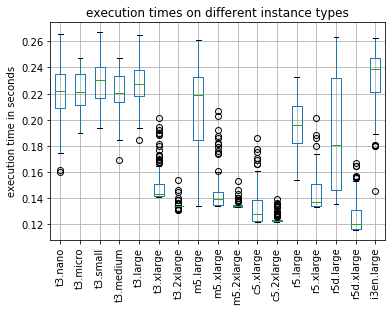

In [24]:
bp1 = results.boxplot(rot=90)
bp1.set_title('execution times on different instance types')
bp1.set_ylabel('execution time in seconds')

### Cost-effectiveness
Here, we multiply the time the computations took by the hourly price of the instance to see how much the computation actually cost us on each type of instance. *(the numbers are very low, since all prices were <$0.50/hr and computation times were less than a second...)*

In [19]:
byPrice = pd.DataFrame(columns = typeList)
for i, thisType in enumerate(typeList):
    byPrice[thisType] = priceList[i] * (results[thisType] / 3600)
byPrice.head()

,t3.nano,t3.micro,t3.small,t3.medium,t3.large,t3.xlarge,t3.2xlarge,m5.large,m5.xlarge,m5.2xlarge,c5.large,c5.xlarge,c5.2xlarge,r5.large,r5.xlarge,r5d.large,r5d.xlarge,i3en.large
0,3.428091e-07,7.173626e-07,0.000002,0.000003,0.000007,0.000008,0.000015,0.000007,0.000010,0.000017,NaN,0.000009,0.000014,0.000009,0.000013,0.000010,0.000012,0.000017
1,3.791916e-07,7.800228e-07,0.000002,0.000003,0.000006,0.000010,0.000015,0.000008,0.000009,0.000017,NaN,0.000008,0.000014,0.000009,0.000011,0.000011,0.000013,0.000014
2,3.679507e-07,8.179314e-07,0.000002,0.000003,0.000006,0.000011,0.000015,0.000008,0.000010,0.000017,NaN,0.000008,0.000014,0.000009,0.000011,0.000011,0.000013,0.000016
3,3.549286e-07,7.938080e-07,0.000001,0.000003,0.000006,0.000008,0.000015,0.000008,0.000009,0.000017,NaN,0.000008,0.000014,0.000007,0.000012,0.000012,0.000012,0.000015
4,3.676448e-07,7.391804e-07,0.000002,0.000003,0.000006,0.000008,0.000015,0.000007,0.000009,0.000017,NaN,0.000008,0.000014,0.000008,0.000012,0.000012,0.000011,0.000018


### Now let's see how adjusting by price changes our perception of instance performance!
Now we see that for the same task, <span style="color:red">the least powerful instance types were actually much more efficient</span> than the more powerful ones in terms of total cost!

So, if you have a lot of time and are really just interested in recursively calculating Fibonacci numbers, then you should do so on a **t3.nano** instance! 

We assume that this price effectiveness will change when you do more complex tasks, such as moving large files between S3 and EC2 instances. This is why the second notebook in our submission for homework 2 is testing this scenario, focussing more on the analysis of the results than on the methods of how to get things running. 

Text(0, 0.5, 'price for execution time of the script')

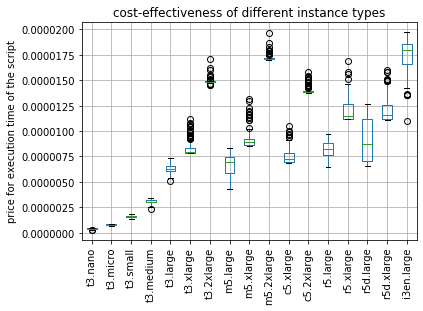

In [23]:
bp2 = byPrice.boxplot(rot=90)
bp2.set_title('cost-effectiveness of different instance types')
bp2.set_ylabel('price for execution time of the script')

In [22]:
# To view this notebook as slides
!jupyter nbconvert hw2psa.ipynb --to slides --post serve